In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures,scale

import pymc3 as pm
from scipy import stats, optimize
from sklearn.datasets import load_diabetes
from sklearn.cross_validation import train_test_split
from theano import shared
import theano.tensor as T

In [30]:
df = pd.read_csv('ccpp.csv')

#Inputs and Output
X = scale(np.array(df.drop(['PE'],1)))
y = scale(np.array(df['PE']))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .20,random_state = 42)

#Preprocess data for Modeling
model_input= shared(X_train)
model_output= shared(y_train)

In [31]:
#Generate Model
linear_model = pm.Model()
with linear_model:
    # Priors for unknown model parameters    

    alpha = pm.Normal("alpha", mu=0,sd=1)
    betas = pm.Normal("betas", mu=0, sd=1, shape=X.shape[1])
    sigma = pm.HalfNormal("sigma", tau=1) # you could also try with a HalfCauchy that has longer/fatter tails
    # Expected value of outcome

    mu = alpha + T.dot(model_input,betas)
    
    # Likelihood (sampling distribution of observations)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=model_output)


In [32]:
#infering parameters
with linear_model:
    inference=pm.ADVI()
    approx = pm.fit(n=5000,more_replacements={
        model_input:pm.Minibatch(X_train),
        model_output:pm.Minibatch(y_train)
                }
        )

Average Loss = 206.34: 100%|███████████████████████████████████████████████████████| 5000/5000 [04:03<00:00, 20.53it/s]
Finished [100%]: Average Loss = 206.11


In [33]:
#Replace shared variable with testing set
model_input.set_value(X_test)
model_output.set_value(y_test)

# Creater posterior predictive samples
trace = approx.sample(draws=5000)
ppc = pm.sample_ppc(trace,model=linear_model,samples=5000)
pred = ppc['y'].mean(axis=0)

print('Accuracy = {}%'.format((y_test - pred).mean() * 100))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 643.03it/s]


Accuracy = -2.536448049900641%


              mean        sd  mc_error   hpd_2.5  hpd_97.5
alpha     0.009329  0.346029  0.005158 -0.660003  0.668944
betas__0 -0.394023  0.430744  0.006113 -1.204527  0.472679
betas__1 -0.365263  0.410743  0.006077 -1.187581  0.431485
betas__2  0.174899  0.378325  0.005130 -0.544896  0.928212
betas__3  0.074066  0.371591  0.004769 -0.675632  0.769870
sigma     1.239514  0.477566  0.007194  0.444966  2.166690


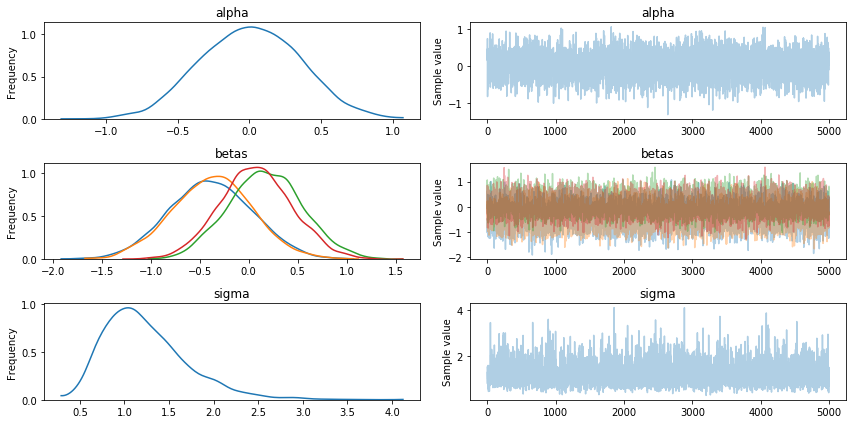

In [34]:
#intrepreting parameters
trace= approx.sample(draws=5000)
print(pm.summary(trace))

pm.plots.traceplot(trace)
plt.show()